In [1]:
import os
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import PIL
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
#设置显示中文字体
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams["axes.unicode_minus"] = False

#图像清晰度调整
%config InlineBackend.figure_format = 'retina'

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <08E12B12-6183-307E-BDA0-374FA8EBA2C9> /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <709C1DF5-D253-3C66-87E2-C99FD3A259DF> /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/transformers/ut

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        return x

class UNetPlusPlus(nn.Module):
    def __init__(self, in_channels=3, num_classes=1):
        super(UNetPlusPlus, self).__init__()
        
        # Encoder (downsampling)
        self.encoder1 = ConvBlock(in_channels, 64)
        self.encoder2 = ConvBlock(64, 128)
        self.encoder3 = ConvBlock(128, 256)
        self.encoder4 = ConvBlock(256, 512)

        # Decoder (upsampling)
        self.decoder4_0 = ConvBlock(512, 256)
        self.decoder3_0 = ConvBlock(256 + 256, 128)
        self.decoder2_0 = ConvBlock(128 + 128, 64)

        # Nested Decoder Blocks
        self.decoder3_1 = ConvBlock(256 + 128 + 128, 128)
        self.decoder2_1 = ConvBlock(128 + 64 + 64, 64)
        self.decoder2_2 = ConvBlock(64 + 64 + 64, 64)

        # Final layer
        self.final = nn.Conv2d(64, num_classes, kernel_size=1)
        
        # Pooling
        self.pool = nn.MaxPool2d(2)
        
    def forward(self, x):
        # Encoding path
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))
        enc4 = self.encoder4(self.pool(enc3))
        
        # Decoding path
        dec4_0 = F.interpolate(enc4, size=enc3.shape[2:], mode='bilinear', align_corners=False)
        dec4_0 = self.decoder4_0(dec4_0)
        
        dec3_0 = torch.cat([dec4_0, enc3], dim=1)
        dec3_0 = self.decoder3_0(dec3_0)
        
        # 调整 dec4_0 和 enc2 的尺寸，使其与 dec3_0 一致
        dec3_1 = F.interpolate(dec3_0, size=enc2.shape[2:], mode='bilinear', align_corners=False)
        enc2_resized = F.interpolate(enc2, size=enc2.shape[2:], mode='bilinear', align_corners=False)
        dec4_0_resized = F.interpolate(dec4_0, size=enc2.shape[2:], mode='bilinear', align_corners=False)
        
        # 拼接尺寸调整后的张量
        dec3_1 = torch.cat([dec3_1, enc2_resized, dec4_0_resized], dim=1)
        dec3_1 = self.decoder3_1(dec3_1)

        dec2_0 = torch.cat([F.interpolate(dec3_0, size=enc2.shape[2:], mode='bilinear', align_corners=False), enc2], dim=1)
        dec2_0 = self.decoder2_0(dec2_0)
        
        dec2_1 = F.interpolate(dec3_1, size=enc1.shape[2:], mode='bilinear', align_corners=False)
        dec2_1 = torch.cat([dec2_1, enc1, F.interpolate(dec2_0, size=enc1.shape[2:], mode='bilinear', align_corners=False)], dim=1)
        dec2_1 = self.decoder2_1(dec2_1)
        
        dec2_2 = torch.cat([F.interpolate(dec2_1, size=enc1.shape[2:], mode='bilinear', align_corners=False), enc1, dec2_1], dim=1)
        dec2_2 = self.decoder2_2(dec2_2)

        # Final layer
        output = self.final(dec2_2)
        return output

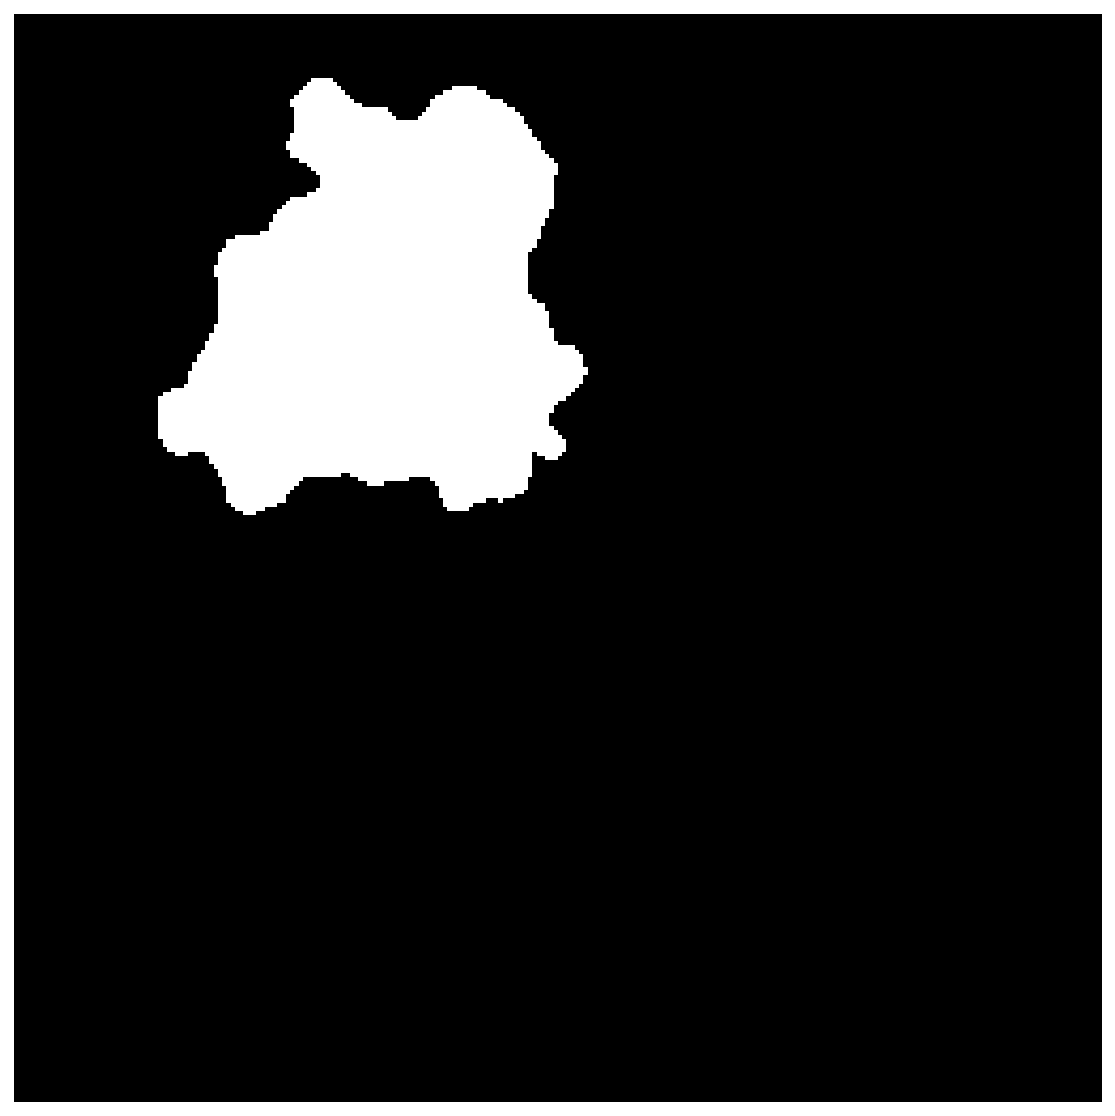

In [5]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np

# 移除 Pillow 对图像大小的限制
Image.MAX_IMAGE_PIXELS = None

# 加载保存的模型
def load_model(model_path, device):
    model = UNetPlusPlus().to(device)  # 使用之前定义的 SimpleUNet 模型架构
    model.load_state_dict(torch.load(model_path, map_location=device))  # 加载模型权重
    model.eval()  # 设置为评估模式
    return model

# 定义测试函数
def test_model(model, test_image_path, transform, device):
    # 加载测试图像
    image = Image.open(test_image_path).convert('RGB')  # 转换为RGB格式
    original_size = image.size  # 获取原始图像大小
    image = transform(image).unsqueeze(0)  # 应用transform并增加batch维度
    image = image.to(device)

    # 进行预测
    with torch.no_grad():
        output = model(image)
        output = torch.sigmoid(output)  # 使用sigmoid激活函数
        predicted_mask = (output > 0.5).float()  # 将输出转换为二值掩码

        # 调整输出掩码为原始图像的大小
        predicted_mask = F.interpolate(predicted_mask, size=original_size[::-1], mode='bilinear', align_corners=False)
        
        # 确保插值后的掩码也是二值化（再进行一次二值化）
        predicted_mask = (predicted_mask > 0.5).float()

    return predicted_mask

# 将预测的掩码部分标红并叠加到原图上（半透明红色）
def apply_mask_on_image(image_path, predicted_mask, alpha=0.5):
    # 打开原始图像
    image = Image.open(image_path).convert('RGB')
    image_np = np.array(image)  # 转换为 NumPy 数组格式

    # 将预测的掩码转换为 NumPy 数组，并调整大小
    predicted_mask = predicted_mask.squeeze().cpu().numpy()

    # 创建红色的遮罩层
    red_mask = np.zeros_like(image_np, dtype=np.uint8)
    red_mask[:, :, 0] = 255  # 将红色通道设为 255 (RGB)

    # 叠加红色遮罩到原图上，使用 alpha 实现半透明效果
    image_with_mask = image_np.copy()
    image_with_mask[predicted_mask == 1] = (1 - alpha) * image_np[predicted_mask == 1] + alpha * red_mask[predicted_mask == 1]

    return Image.fromarray(np.uint8(image_with_mask))

# 可视化测试结果并保存黑白掩码图像
def visualize_results(original_image_path, image_with_mask, predicted_mask):
    # 只显示黑白二值化掩码
    predicted_mask = predicted_mask.squeeze().cpu().numpy()  # 转换为 NumPy 格式

    # 显示二值化掩码
    plt.figure(figsize=(10, 10))

    # 黑白二值化掩码
    plt.imshow(predicted_mask, cmap='gray')
    plt.axis('off')

    # 保存图像到桌面
    output_path = '/Users/camus/Desktop/predicted_binary_mask.png'  # 保存路径
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)

    # 显示图像
    plt.show()

# 设置测试参数
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = 'UNet++_model.pth'  # 你训练好的模型路径
# test_image_path = '/Users/camus/Desktop/虫害/part1.jpg'  # 你的测试图像路径
# test_image_path = '/Users/camus/Desktop/trainX/image/image-124.png'  # 你的测试图像路径

test_image_path = '/Users/camus/Desktop/trainX/image/image-210.png'  # 你的测试图像路径

# 图像预处理
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# 加载模型
model = load_model(model_path, device)

# 运行测试
predicted_mask = test_model(model, test_image_path, transform, device)

# 将预测的掩码部分标红
image_with_mask = apply_mask_on_image(test_image_path, predicted_mask)

# 可视化结果
visualize_results(test_image_path, image_with_mask, predicted_mask)

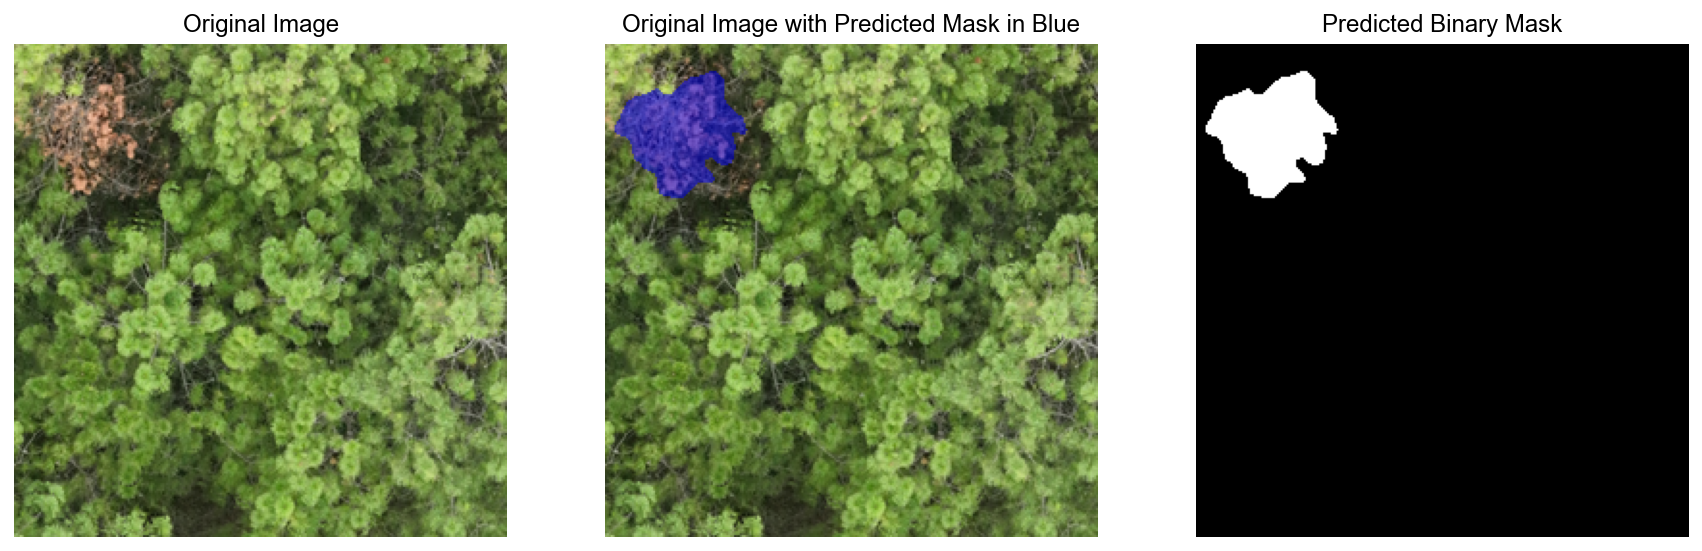

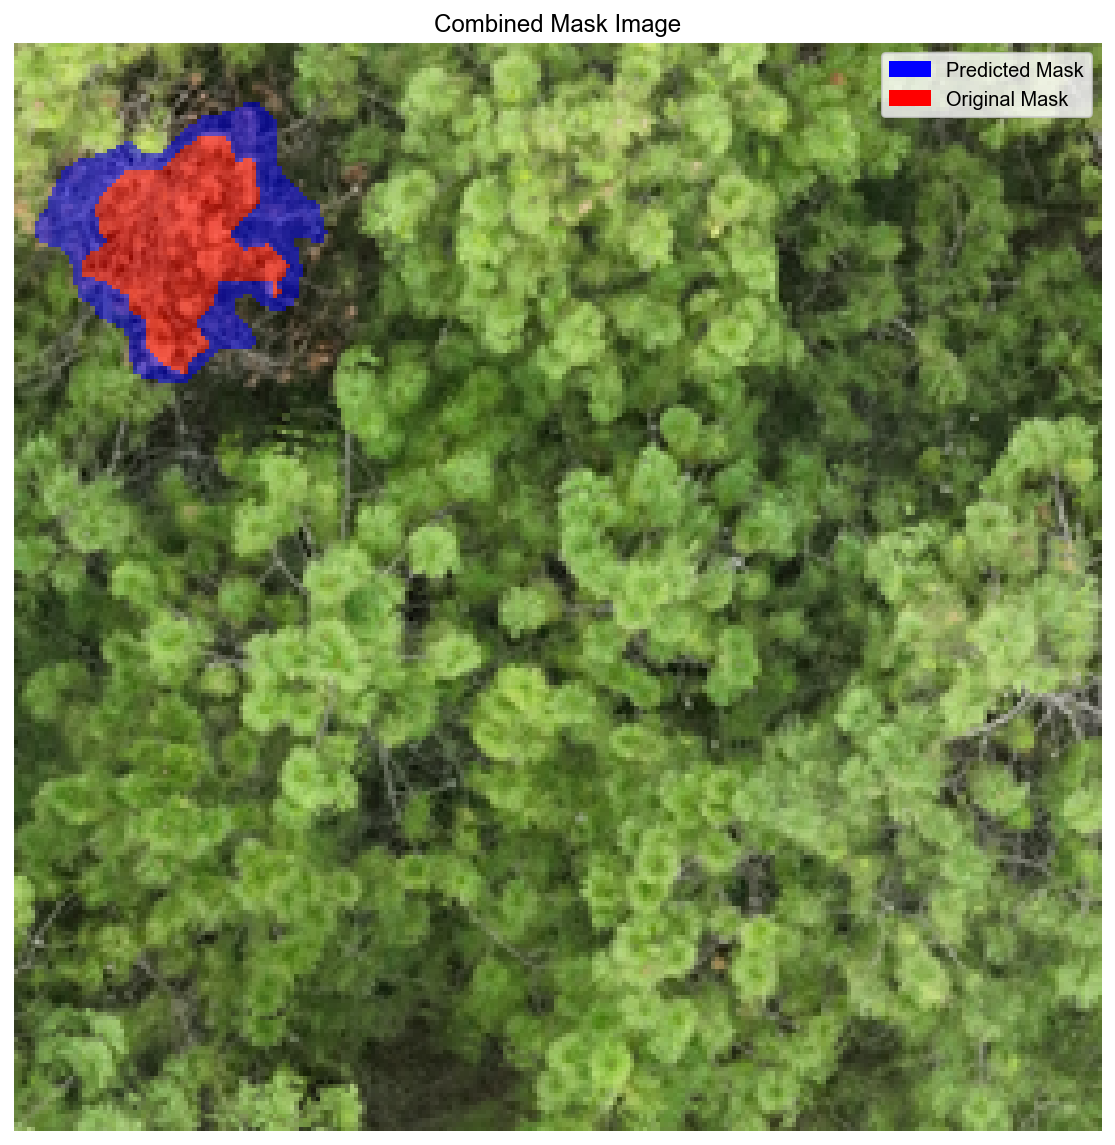

In [4]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
import matplotlib.patches as mpatches

# 移除 Pillow 对图像大小的限制
Image.MAX_IMAGE_PIXELS = None

# 加载保存的模型
def load_model(model_path, device):
    model = UNetPlusPlus().to(device)  # 使用之前定义的 SimpleUNet 模型架构
    model.load_state_dict(torch.load(model_path, map_location=device))  # 加载模型权重
    model.eval()  # 设置为评估模式
    return model

# 定义测试函数
def test_model(model, test_image_path, transform, device):
    # 加载测试图像
    image = Image.open(test_image_path).convert('RGB')  # 转换为RGB格式
    original_size = image.size  # 获取原始图像大小
    image = transform(image).unsqueeze(0)  # 应用transform并增加batch维度
    image = image.to(device)

    # 进行预测
    with torch.no_grad():
        output = model(image)
        output = torch.sigmoid(output)  # 使用sigmoid激活函数
        predicted_mask = (output > 0.5).float()  # 将输出转换为二值掩码

        # 调整输出掩码为原始图像的大小
        predicted_mask = F.interpolate(predicted_mask, size=original_size[::-1], mode='bilinear', align_corners=False)
        
        # 确保插值后的掩码也是二值化（再进行一次二值化）
        predicted_mask = (predicted_mask > 0.5).float()

    return predicted_mask

# 将预测掩码部分标蓝并叠加到原图上（蓝色掩码）
def apply_mask_on_image_with_blue(image_path, predicted_mask, alpha=0.5):
    # 打开原始图像
    image = Image.open(image_path).convert('RGB')
    image_np = np.array(image)  # 转换为 NumPy 数组格式

    # 将预测的掩码转换为 NumPy 数组，并调整大小
    predicted_mask = predicted_mask.squeeze().cpu().numpy()

    # 创建蓝色的遮罩层
    blue_mask = np.zeros_like(image_np, dtype=np.uint8)
    blue_mask[:, :, 2] = 255  # 将蓝色通道设为 255 (RGB)

    # 叠加蓝色遮罩到原图上，使用 alpha 实现半透明效果
    image_with_mask = image_np.copy()
    image_with_mask[predicted_mask == 1] = (1 - alpha) * image_np[predicted_mask == 1] + alpha * blue_mask[predicted_mask == 1]

    return Image.fromarray(np.uint8(image_with_mask))

# 将预测掩码和原始掩码叠加在原图上，分别以蓝色和红色透明显示
def apply_mask_on_image_with_alpha(image_path, predicted_mask, original_mask_path, alpha=0.5):
    # 打开原始图像
    image = Image.open(image_path).convert('RGB')
    image_np = np.array(image)  # 转换为 NumPy 数组格式

    # 将预测的掩码和原始掩码转换为 NumPy 数组，并调整大小
    predicted_mask = predicted_mask.squeeze().cpu().numpy()
    original_mask = Image.open(original_mask_path).convert('L')
    original_mask = np.array(original_mask.resize(image_np.shape[:2][::-1])) / 255  # 归一化

    # 创建蓝色和红色的遮罩层
    blue_mask = np.zeros_like(image_np, dtype=np.uint8)
    blue_mask[:, :, 2] = 255  # 将蓝色通道设为 255
    red_mask = np.zeros_like(image_np, dtype=np.uint8)
    red_mask[:, :, 0] = 255  # 将红色通道设为 255

    # 叠加蓝色（预测掩码）和红色（原始掩码）的透明遮罩
    image_with_mask = image_np.copy()
    image_with_mask[predicted_mask == 1] = (1 - alpha) * image_np[predicted_mask == 1] + alpha * blue_mask[predicted_mask == 1]
    image_with_mask[original_mask == 1] = (1 - alpha) * image_np[original_mask == 1] + alpha * red_mask[original_mask == 1]

    return Image.fromarray(np.uint8(image_with_mask))

# 单独显示蓝红叠加图并添加图例注释
def show_combined_mask_image_with_legend(image_with_mask):
    plt.figure(figsize=(10, 10))  # 调整图像大小
    plt.imshow(image_with_mask)
    plt.title("Combined Mask Image")
    plt.axis('off')

    # 创建图例注释
    blue_patch = mpatches.Patch(color='blue', label='Predicted Mask')
    red_patch = mpatches.Patch(color='red', label='Original Mask')
    plt.legend(handles=[blue_patch, red_patch], loc='upper right')  # 图例位置在右上角

    plt.show()

# 可视化测试结果
def visualize_results(original_image_path, image_with_blue_mask, predicted_mask):
    original_image = Image.open(original_image_path)
    predicted_mask = predicted_mask.squeeze().cpu().numpy()  # 转换为 NumPy 格式

    # 显示三张图片
    plt.figure(figsize=(15, 5))

    # 原图
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis('off')

    # 蓝色掩码叠加图
    plt.subplot(1, 3, 2)
    plt.imshow(image_with_blue_mask)
    plt.title("Original Image with Predicted Mask in Blue")
    plt.axis('off')

    # 黑白二值化掩码
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title("Predicted Binary Mask")
    plt.axis('off')

    # 显示所有图像
    plt.show()

# 设置测试参数
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = 'UNet++_model.pth'  # 你训练好的模型路径
test_image_path = '/Users/camus/Desktop/trainX/image/image-124.png'  # 你的测试图像路径
original_mask_path = '/Users/camus/Desktop/image-124_binary.png'  # 原始掩码图像路径

# 图像预处理
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# 加载模型
model = load_model(model_path, device)

# 运行测试
predicted_mask = test_model(model, test_image_path, transform, device)

# 将预测的掩码部分标蓝
image_with_blue_mask = apply_mask_on_image_with_blue(test_image_path, predicted_mask)

# 可视化结果
visualize_results(test_image_path, image_with_blue_mask, predicted_mask)

# 生成叠加有透明蓝红掩码的图像
image_with_mask = apply_mask_on_image_with_alpha(test_image_path, predicted_mask, original_mask_path)

# 显示结果并添加注释
show_combined_mask_image_with_legend(image_with_mask)